In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jbrichardet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jbrichardet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jbrichardet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/jbrichardet/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Import des données

In [3]:
dataset = pd.read_csv('dataset.csv')[['Body', 'Tags']]
dataset

,Body,Tags
0,<p>I have a UIImageView that I have already se...,<iphone><uiimageview><uiimage>
1,<blockquote>\n <p><strong>Possible Duplicate:...,<delphi><file-permissions>
2,<h2>The requirements I'm up against</h2>\n\n<p...,<c#><winforms>
3,"<p>I keep getting the following error ""Could n...",<wcf><https><transport><credentials>
4,<p>I am using the xml-simple gem inside a rake...,<ruby><xml><xml-simple>
...,...,...
99707,<p>Is it possible to have a singleton in a fac...,<java>
99708,<p>I was wondering if there is some option to ...,<c#><visual-studio-2008><resharper><using-dire...
99709,"<p>I have found the ""Getting Started"" document...",<iphone><xcode>
99710,"<p>I have a 2D area with ""dots"" distributed on...",<algorithm><data-structures><image-processing>


# Suppression des tags les moins communs

In [4]:
dataset['Tags'] = dataset['Tags'].str.split(r'<(.+?)>').apply(lambda x: [tag for tag in x if tag != ''])

In [5]:
tagsFreq = dataset['Tags'].to_frame().apply(lambda x : pd.Series([x['Tags'], nltk.FreqDist(x['Tags'])], index=['tokens', 'frequency']), axis=1, result_type='expand')

In [6]:
total_freq = {}
for dictionnary in tagsFreq['frequency']:
    for k,v in dictionnary.items():
        if k in total_freq:
            total_freq[k] += v
        else:
            total_freq[k] = v

freq_list = sorted(total_freq.items(), key=lambda x: x[1], reverse=True)
freq_list

[('c#', 11112),
 ('java', 7667),
 ('.net', 6707),
 ('javascript', 6300),
 ('php', 5567),
 ('c++', 4964),
 ('asp.net', 4824),
 ('python', 4671),
 ('jquery', 3406),
 ('html', 3278),
 ('sql', 3174),
 ('sql-server', 2610),
 ('mysql', 2528),
 ('android', 2433),
 ('iphone', 2372),
 ('css', 2162),
 ('c', 2065),
 ('windows', 1880),
 ('ruby-on-rails', 1706),
 ('database', 1619),
 ('visual-studio', 1492),
 ('xml', 1482),
 ('ruby', 1471),
 ('wpf', 1370),
 ('asp.net-mvc', 1370),
 ('objective-c', 1317),
 ('vb.net', 1214),
 ('winforms', 1200),
 ('linux', 1198),
 ('regex', 1183),
 ('performance', 1086),
 ('ajax', 1041),
 ('arrays', 984),
 ('visual-studio-2008', 916),
 ('multithreading', 914),
 ('oracle', 897),
 ('django', 883),
 ('algorithm', 879),
 ('string', 878),
 ('svn', 856),
 ('web-services', 852),
 ('unit-testing', 820),
 ('security', 801),
 ('linq', 801),
 ('ios', 772),
 ('eclipse', 752),
 ('macos', 724),
 ('user-interface', 711),
 ('excel', 702),
 ('winapi', 697),
 ('perl', 695),
 ('sql-serv

In [7]:
idx, values = zip(*freq_list)
frequencies = pd.Series(values, idx)
frequencies.describe()

count    16255.000000
mean        17.786835
std        175.048205
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      11112.000000
dtype: float64

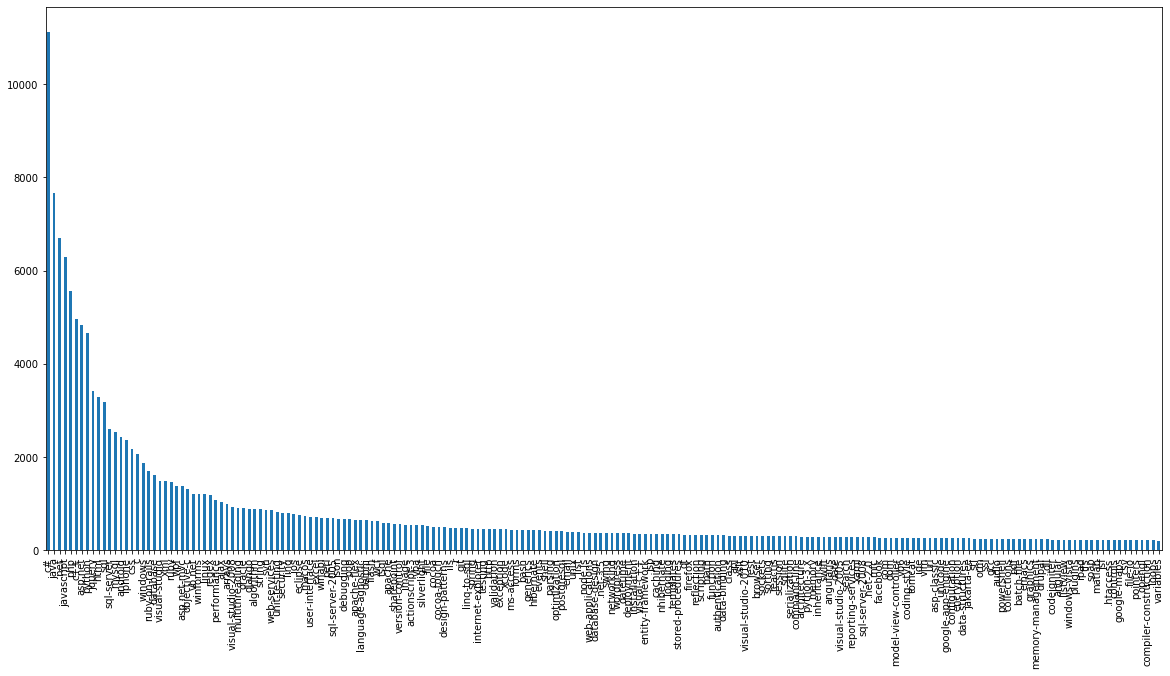

count      200.00000
mean       819.00000
std       1348.47927
min        206.00000
25%        271.75000
50%        367.00000
75%        695.50000
max      11112.00000
dtype: float64

In [8]:
top = frequencies.head(200)
top.plot(kind='bar', figsize=(20, 10))
plt.show()
top.describe()

## Filtre des tags les moins fréquents

In [9]:
keeped_tags = frequencies[:50] #frequencies[frequencies >= 300]
tags = dataset['Tags'].apply(lambda x: [tag for tag in x if tag in keeped_tags])
tags = tags[tags.str.len() != 0]
tags

0                        [iphone]
2                  [c#, winforms]
4                     [ruby, xml]
5                           [php]
7           [python, sql, django]
                   ...           
99706                       [c++]
99707                      [java]
99708    [c#, visual-studio-2008]
99709                    [iphone]
99710                 [algorithm]
Name: Tags, Length: 75689, dtype: object

In [10]:
dataset = dataset.loc[tags.index]
dataset['Tags'] = tags

In [11]:
dataset['Tags'].apply(lambda x: len(x)).describe()

count    75689.000000
mean         1.470597
std          0.674153
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: Tags, dtype: float64

In [12]:
tagsFreq = dataset['Tags'].to_frame().apply(lambda x : pd.Series([x['Tags'], nltk.FreqDist(x['Tags'])], index=['tokens', 'frequency']), axis=1, result_type='expand')
total_freq = {}
for dictionnary in tagsFreq['frequency']:
    for k,v in dictionnary.items():
        if k in total_freq:
            total_freq[k] += v
        else:
            total_freq[k] = v

freq_list = sorted(total_freq.items(), key=lambda x: x[1], reverse=True)
freq_list
idx, values = zip(*freq_list)
frequencies = pd.Series(values, idx)
frequencies.describe()

count       50.000000
mean      2226.160000
std       2154.634969
min        697.000000
25%        880.000000
50%       1343.500000
75%       2504.250000
max      11112.000000
dtype: float64

# Tokenization

In [13]:
from langdetect import detect
lang = dataset['Body'].apply(detect)
lang

0        en
2        en
4        en
5        en
7        en
         ..
99706    en
99707    en
99708    en
99709    en
99710    en
Name: Body, Length: 75689, dtype: object

In [14]:
dataset.drop(lang[lang != 'en'].index, inplace=True)

In [25]:
html_tags_re = re.compile("<.+?>|\\n|\\|\\t/g")
posts = dataset['Body'].str.replace(html_tags_re, '')

### Intermediate export

In [27]:
%store dataset

Stored 'dataset' (DataFrame)


In [15]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
tokens = posts.str.lower().map(tokenizer.tokenize)
tokens

0        [i, have, a, uiimageview, that, i, have, alrea...
2        [the, requirements, i, m, up, againstabout, pe...
4        [i, am, using, the, xml, simple, gem, inside, ...
5        [i, m, trying, to, get, a, php, array, that, i...
7        [i, have, done, some, google, searching, and, ...
                               ...                        
99706    [so, i, m, trying, to, get, rid, of, my, std, ...
99707    [is, it, possible, to, have, a, singleton, in,...
99708    [i, was, wondering, if, there, is, some, optio...
99709    [i, have, found, the, getting, started, docume...
99710    [i, have, a, d, area, with, dots, distributed,...
Name: Body, Length: 75467, dtype: object

## Nombre de mots par post

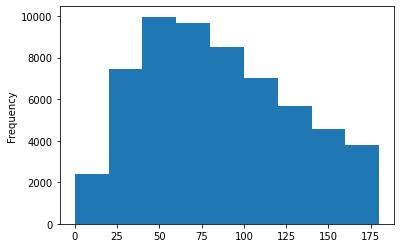

count    75467.000000
mean       136.882359
std        147.590371
min          2.000000
25%         58.000000
50%         99.000000
75%        167.000000
max       4061.000000
Name: Body, dtype: float64

In [16]:
posts_size = tokens.map(len)
posts_size.plot.hist(bins=np.arange(0, 200, 20))
plt.show()
posts_size.describe()

## Nombre de mots uniques par post

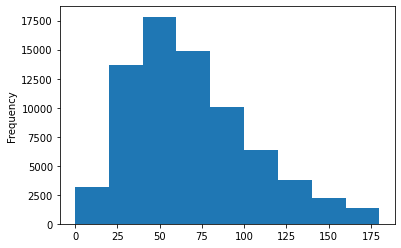

count    75467.000000
mean        72.698464
std         44.944345
min          2.000000
25%         42.000000
50%         63.000000
75%         93.000000
max        567.000000
Name: Body, dtype: float64

In [17]:
posts_unique_size = tokens.map(lambda x: len(np.unique(x)))
posts_unique_size.plot.hist(bins=np.arange(0,200,20))
plt.show()
posts_unique_size.describe()

# Recherche des mots les plus courants

In [18]:
vocabulary = tokens.to_frame().apply(lambda x : pd.Series([x['Body'], nltk.FreqDist(x['Body'])], index=['tokens', 'frequency']), axis=1, result_type='expand')
vocabulary

,tokens,frequency
0,"[i, have, a, uiimageview, that, i, have, alrea...","{'i': 6, 'have': 2, 'a': 3, 'uiimageview': 4, ..."
2,"[the, requirements, i, m, up, againstabout, pe...","{'the': 16, 'requirements': 1, 'i': 3, 'm': 1,..."
4,"[i, am, using, the, xml, simple, gem, inside, ...","{'i': 1, 'am': 1, 'using': 1, 'the': 5, 'xml':..."
5,"[i, m, trying, to, get, a, php, array, that, i...","{'i': 3, 'm': 1, 'trying': 1, 'to': 3, 'get': ..."
7,"[i, have, done, some, google, searching, and, ...","{'i': 4, 'have': 2, 'done': 1, 'some': 2, 'goo..."
...,...,...
99706,"[so, i, m, trying, to, get, rid, of, my, std, ...","{'so': 2, 'i': 7, 'm': 3, 'trying': 2, 'to': 1..."
99707,"[is, it, possible, to, have, a, singleton, in,...","{'is': 1, 'it': 1, 'possible': 1, 'to': 1, 'ha..."
99708,"[i, was, wondering, if, there, is, some, optio...","{'i': 2, 'was': 1, 'wondering': 1, 'if': 1, 't..."
99709,"[i, have, found, the, getting, started, docume...","{'i': 4, 'have': 1, 'found': 1, 'the': 3, 'get..."


In [19]:
dfs = [pd.DataFrame.from_dict(value, orient='index') for value in vocabulary['frequency'].values]
dfs

[              0
 i             6
 have          2
 a             3
 uiimageview   4
 that          3
 already       1
 set           3
 an            1
 image        11
 to            3
 this          1
 works         1
 fine          1
 but           2
 later         1
 want          1
 change        1
 so            1
 new           1
 for           1
 the           4
 property      1
 when          1
 view          1
 app           1
 is            1
 as            1
 second        1
 over          1
 first         1
 cell          1
 viewwithtag   1
 uiimage       1
 imagenamed    1
 history       1
 row           1
 png           1
 how           1
 can           1
 replace       1
 current       1
 in            1
 my            1
 rather        1
 than          1
 seeming       1
 add           1
 another       1,
                0
 the           16
 requirements   1
 i              3
 m              1
 up             3
 ...           ..
 after          1
 event          1
 has

In [20]:
total_freq = {}
for dictionnary in vocabulary['frequency']:
    for k,v in dictionnary.items():
        if k in total_freq:
            total_freq[k] += v
        else:
            total_freq[k] = v

In [21]:
freq_list = sorted(total_freq.items(), key=lambda x: x[1], reverse=True)
freq_list

[('the', 390478),
 ('i', 319948),
 ('to', 270121),
 ('a', 224660),
 ('gt', 181288),
 ('lt', 165978),
 ('is', 146730),
 ('and', 133440),
 ('in', 130778),
 ('of', 110046),
 ('this', 104470),
 ('it', 101971),
 ('that', 93174),
 ('for', 78201),
 ('have', 64945),
 ('on', 55369),
 ('if', 55358),
 ('but', 54454),
 ('with', 54239),
 ('my', 53930),
 ('be', 50258),
 ('t', 47341),
 ('can', 46620),
 ('as', 45996),
 ('not', 44670),
 ('s', 41260),
 ('an', 41040),
 ('from', 40254),
 ('m', 39972),
 ('do', 37914),
 ('or', 35693),
 ('class', 35219),
 ('id', 34075),
 ('like', 33636),
 ('using', 33495),
 ('new', 33477),
 ('code', 33124),
 ('there', 32967),
 ('so', 32695),
 ('how', 32186),
 ('what', 30890),
 ('are', 30519),
 ('c', 30383),
 ('get', 30119),
 ('when', 29917),
 ('name', 29190),
 ('string', 28929),
 ('data', 28365),
 ('at', 28090),
 ('am', 28011),
 ('file', 27795),
 ('would', 27056),
 ('any', 26919),
 ('use', 25154),
 ('you', 24165),
 ('which', 24129),
 ('want', 23848),
 ('some', 23569),
 ('all

In [22]:
idx, values = zip(*freq_list)
frequencies = pd.Series(values, idx)
frequencies.describe()

count    210619.000000
mean         49.046387
std        1741.859764
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      390478.000000
dtype: float64

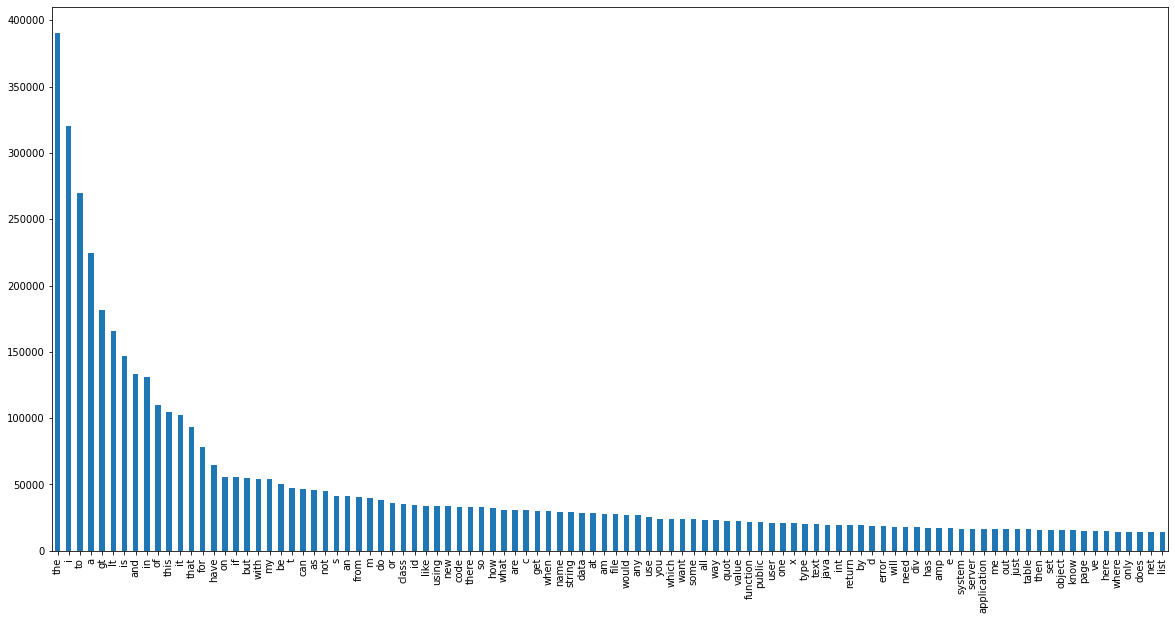

count       100.000000
mean      48063.180000
std       62715.000016
min       14169.000000
25%       18509.750000
50%       27903.000000
75%       42112.500000
max      390478.000000
dtype: float64

In [23]:
top = frequencies.head(100)
top.plot(kind='bar', figsize=(20, 10))
plt.show()
top.describe()

15

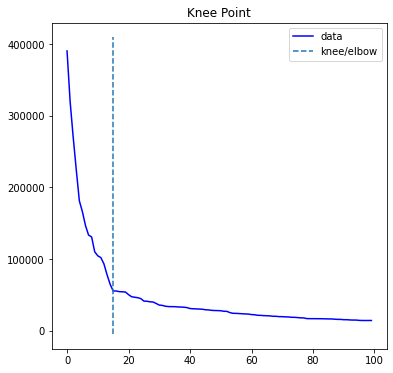

In [24]:
knee = KneeLocator([i for i,_ in enumerate(top.index.values)], top.values, curve='convex', direction='decreasing')
knee.plot_knee()
knee.knee

In [25]:
frequencies.iloc[:knee.knee+1]

the     390478
i       319948
to      270121
a       224660
gt      181288
lt      165978
is      146730
and     133440
in      130778
of      110046
this    104470
it      101971
that     93174
for      78201
have     64945
on       55369
dtype: int64

# Création d'une liste de stopwords

In [26]:
en_stopwords = nltk.corpus.stopwords.words('english')
to_drop = frequencies.index.intersection(en_stopwords)
to_drop

Index(['the', 'i', 'to', 'a', 'is', 'and', 'in', 'of', 'this', 'it',
       ...
       'himself', 'whom', 'yours', 'ain', 'mustn', 'herself', 'shan', 'needn',
       'hers', 'yourselves'],
      dtype='object', length=152)

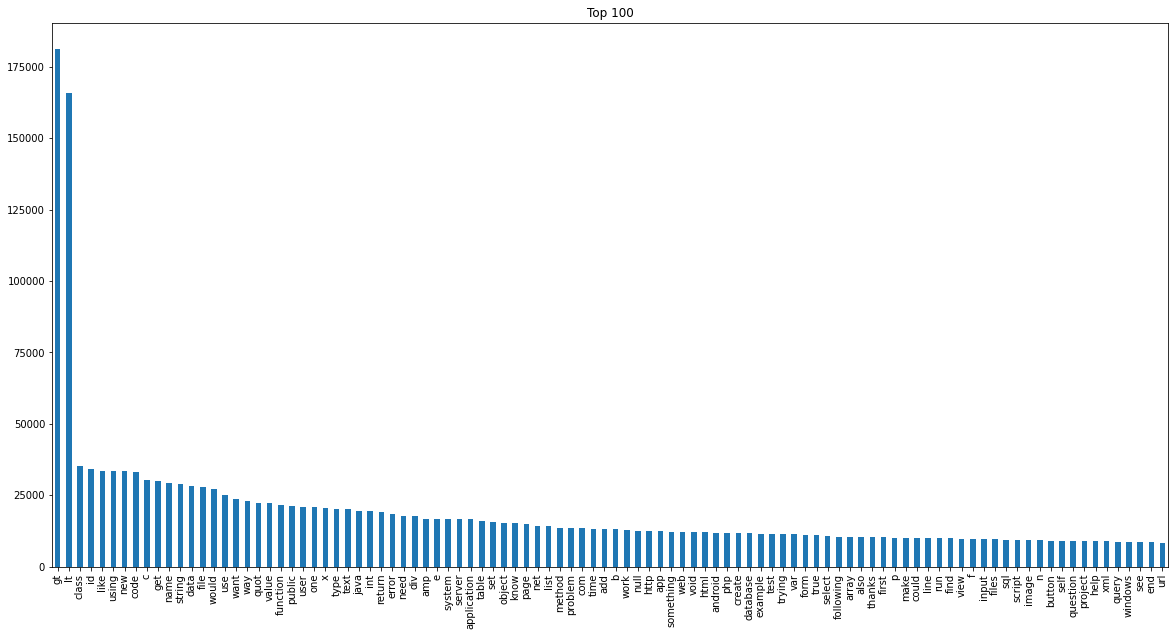

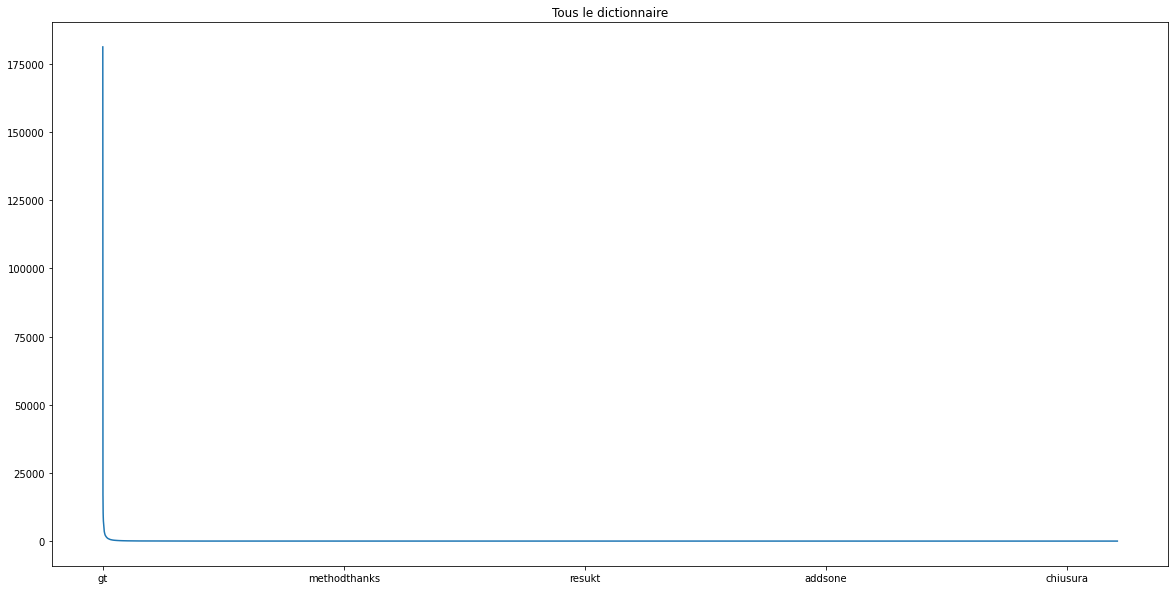

count    210467.000000
mean         30.664565
std         688.775793
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      181288.000000
dtype: float64

In [27]:
freq_wo_stop = frequencies.drop(to_drop)
freq_wo_stop.head(100).plot(kind='bar', figsize=(20,10))
plt.title('Top 100')
plt.show()
freq_wo_stop.plot(figsize=(20,10))
plt.title('Tous le dictionnaire')
plt.show()
freq_wo_stop.describe()

477

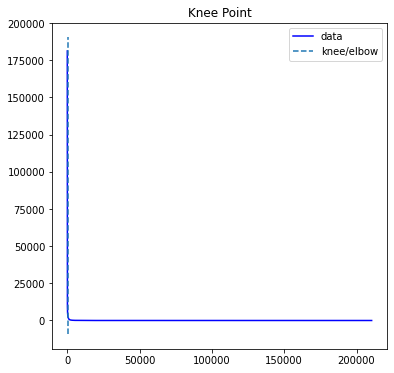

In [28]:
knee = KneeLocator([i for i,_ in enumerate(freq_wo_stop.index.values)], freq_wo_stop.values, curve='convex', direction='decreasing')
knee.plot_knee()
knee.knee

In [29]:
sw = freq_wo_stop[:knee.knee+1].index.tolist() + en_stopwords
sw

['gt',
 'lt',
 'class',
 'id',
 'like',
 'using',
 'new',
 'code',
 'c',
 'get',
 'name',
 'string',
 'data',
 'file',
 'would',
 'use',
 'want',
 'way',
 'quot',
 'value',
 'function',
 'public',
 'user',
 'one',
 'x',
 'type',
 'text',
 'java',
 'int',
 'return',
 'error',
 'need',
 'div',
 'amp',
 'e',
 'system',
 'server',
 'application',
 'table',
 'set',
 'object',
 'know',
 'page',
 'net',
 'list',
 'method',
 'problem',
 'com',
 'time',
 'add',
 'b',
 'work',
 'null',
 'http',
 'app',
 'something',
 'web',
 'void',
 'html',
 'android',
 'php',
 'create',
 'database',
 'example',
 'test',
 'trying',
 'var',
 'form',
 'true',
 'select',
 'following',
 'array',
 'also',
 'thanks',
 'first',
 'p',
 'make',
 'could',
 'line',
 'run',
 'find',
 'view',
 'f',
 'input',
 'files',
 'sql',
 'script',
 'image',
 'n',
 'button',
 'self',
 'question',
 'project',
 'help',
 'xml',
 'query',
 'windows',
 'see',
 'end',
 'url',
 'px',
 'item',
 'key',
 'content',
 'number',
 'tried',
 'call',


# Recalcul de la taille par post sans stopwords

In [30]:
normalized_tokens = posts.str.lower().map(lambda x: [token for token in tokenizer.tokenize(x) if not token in sw])
normalized_tokens

0        [uiimageview, later, uiimageview, uiimageview,...
2        [requirements, againstabout, people, tradition...
4        [gem, rake, parse, contents, dump, characters,...
5        [includes, nested, primary, links, sub, straig...
7        [searching, django, stuff, django, struggling,...
                               ...                        
99706    [rid, vector, ptr, vector, removed, deleted, o...
99707               [singleton, factory, domains, factory]
99708    [resharper, removing, directive, perhaps, conf...
99709    [started, documents, developing, apps, iphone,...
99710    [area, dots, distributed, area, detect, cluste...
Name: Body, Length: 75467, dtype: object

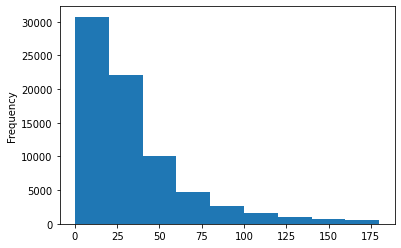

count    75467.000000
mean        39.200326
std         57.888408
min          0.000000
25%         13.000000
50%         24.000000
75%         45.000000
max       1940.000000
Name: Body, dtype: float64

In [31]:
norm_posts_size = normalized_tokens.map(len)
norm_posts_size.plot.hist(bins=np.arange(0, 200, 20))
plt.show()
norm_posts_size.describe()

# Lemmatisation

In [32]:
wnl = WordNetLemmatizer()
lem_tokens = normalized_tokens.map(lambda x: [wnl.lemmatize(w) for w in x])
lem_tokens

0        [uiimageview, later, uiimageview, uiimageview,...
2        [requirement, againstabout, people, traditiona...
4        [gem, rake, parse, content, dump, character, c...
5        [includes, nested, primary, link, sub, straigh...
7        [searching, django, stuff, django, struggling,...
                               ...                        
99706    [rid, vector, ptr, vector, removed, deleted, o...
99707                [singleton, factory, domain, factory]
99708    [resharper, removing, directive, perhaps, conf...
99709    [started, document, developing, apps, iphone, ...
99710    [area, dot, distributed, area, detect, cluster...
Name: Body, Length: 75467, dtype: object

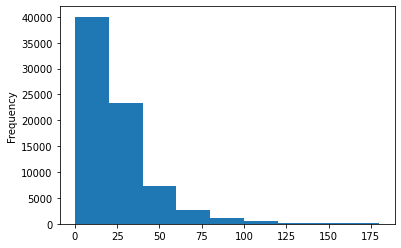

count    75467.000000
mean        24.353148
std         22.252528
min          0.000000
25%         10.000000
50%         18.000000
75%         31.000000
max        399.000000
Name: Body, dtype: float64

In [33]:
lem_posts_unique_size = lem_tokens.map(lambda x: len(np.unique(x)))
lem_posts_unique_size.plot.hist(bins=np.arange(0,200,20))
plt.show()
lem_posts_unique_size.describe()

# Merge

In [34]:
dataset['Body'] = lem_tokens
dataset.reset_index(inplace=True, drop=True)
dataset

,Body,Tags
0,"[uiimageview, later, uiimageview, uiimageview,...",[iphone]
1,"[requirement, againstabout, people, traditiona...","[c#, winforms]"
2,"[gem, rake, parse, content, dump, character, c...","[ruby, xml]"
3,"[includes, nested, primary, link, sub, straigh...",[php]
4,"[searching, django, stuff, django, struggling,...","[python, sql, django]"
...,...,...
75462,"[rid, vector, ptr, vector, removed, deleted, o...",[c++]
75463,"[singleton, factory, domain, factory]",[java]
75464,"[resharper, removing, directive, perhaps, conf...","[c#, visual-studio-2008]"
75465,"[started, document, developing, apps, iphone, ...",[iphone]


In [35]:
body_content = [' '.join(words) for words in dataset['Body'].values]
dataset['Body'] = body_content
dataset.drop(dataset[dataset['Body'] == ''].index, inplace=True)

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75363 entries, 0 to 75466
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    75363 non-null  object
 1   Tags    75363 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [37]:
dataset.to_csv('./cleaned_dataset.csv', index=False)